In [1]:
import sys
sys.path.insert(1, "../python/architecture")
sys.path.insert(2, "../python/functions")

In [2]:
import numpy as np
from inverse_problem_functions import y_noise
from enkf_functions import enkf_inverse_problem
from plotting_functions import plot_IP_loss_evolution, plot_IP_loss_evolution_many, plot_IP_true_false, plot_IP_particle_loss, plot_IP_particle_std, plot_IP_iteration_std

# Lineares Modell

## Modell:
$Ax=y$ mit $A$ $m\times n$-Matrix, $m$, $n$ beliebig ($A$ also insbesondere nicht zwingend quadratisch).

$x$ wird gesucht.

In [3]:
A = np.random.uniform(size = (10000, 100))
x = np.random.uniform(size = (A.shape[1], ))

In [4]:
def model_func(x):
    return np.dot(A, x)

In [5]:
noise = False

y, std = y_noise(model_func,
                 x, 
                 noise)

In [6]:
setting_dict = {"model_func": model_func,
                "x": x,
                "y": y,
                "particles": 50,
                "iterations": 25,
                "noise": noise,
                "std": std,
                "h_0": 2,
                "epsilon": 0.5,
                }

In [7]:
return_dict = enkf_inverse_problem(setting_dict)

final_params = return_dict["final_params"]
loss_evolution = return_dict["loss_evolution"]
loss_evolution_single_dict = return_dict["loss_evolution_single_dict"]

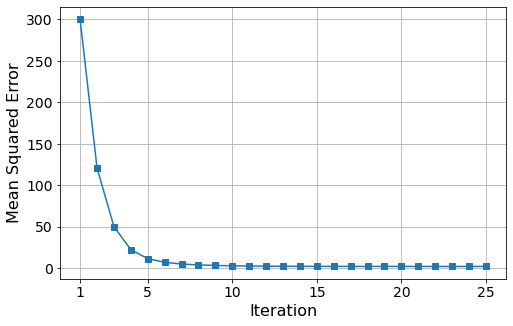

In [8]:
plot_IP_loss_evolution(return_dict,
                       start_iteration = 1,
                       reg_line = False,
                       xlabel = "Iteration",
                       save = None)#"../img/inverse_problem/loss_single_linear_noNoise.png")

Substituting symbol G from STIXNonUnicode
Substituting symbol G from STIXNonUnicode


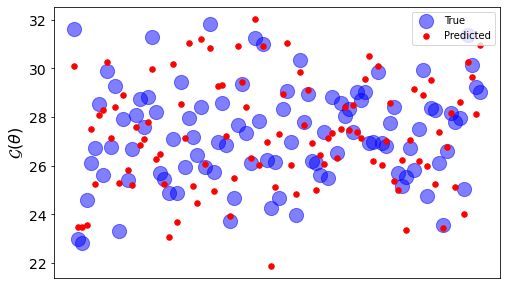

In [9]:
plot_IP_true_false(setting_dict,
                   final_params,
                   num_points = 100,
                   x_axis = False,
                   save = None)#"../img/inverse_problem/true_pred_linear_noNoise.png")

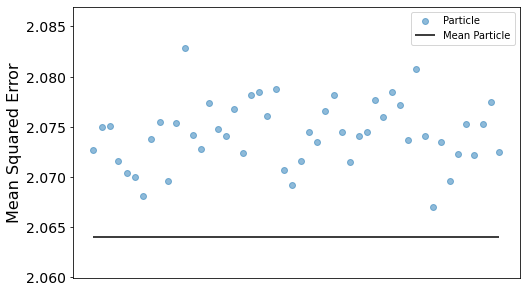

In [10]:
plot_IP_particle_loss(loss_evolution,
                      loss_evolution_single_dict,
                      rel_limit_exceed = 0.002,
                      save = None)#"../img/inverse_problem/particles_linear_noNoise.png")

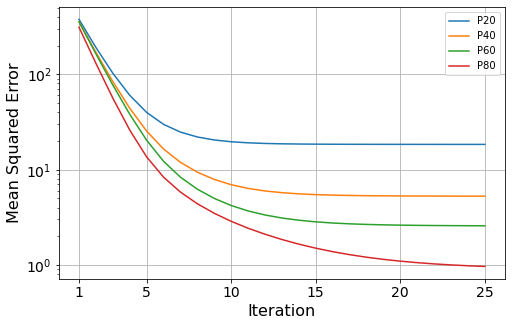

In [11]:
particle_list = [20, 40, 60, 80]

plot_IP_loss_evolution_many(setting_dict,
                            particle_list,
                            start_iteration = 1,
                            end_iteration = setting_dict["iterations"],
                            log = True,
                            xlabel = "Iteration",
                            analysis_dict = None,
                            linear = True,
                            save = None)#"../img/inverse_problem/loss_many_linear_noNoise.png")

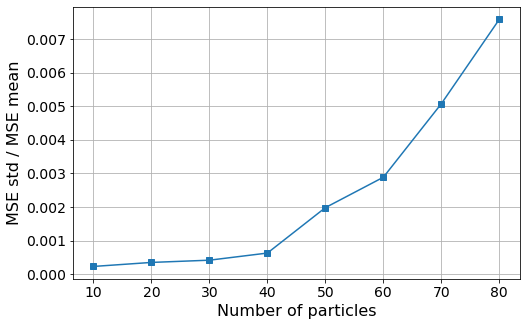

In [12]:
particle_list = [10, 20, 30, 40, 50, 60, 70, 80]

plot_IP_particle_std(setting_dict,
                     particle_list,
                     save = None)#"../img/inverse_problem/std_particles_linear_noNoise.png")

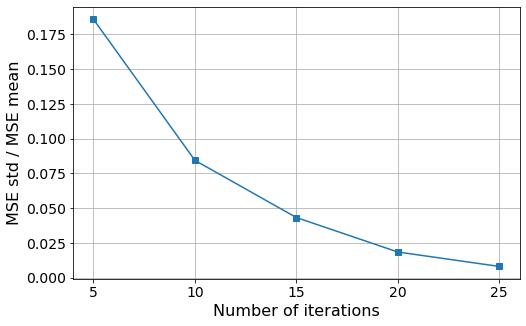

In [13]:
iteration_list = [5, 10, 15, 20, 25]

plot_IP_iteration_std(setting_dict,
                      iteration_list,
                      xlabel = "Iteration",
                      save = None)#"../img/inverse_problem/std_iteration_linear_noNoise.png")

## Modell:
$Ax=y + \eta$ mit $A$ $m\times n$-Matrix, $m$, $n$ beliebig ($A$ also insbesondere nicht zwingend quadratisch), $\eta\sim\mathscr{N}(0,\Gamma)$.

$x$ wird gesucht.

In [3]:
np.random.seed(42)
A = np.random.uniform(size = (1000, 100))
x = np.random.uniform(size = (A.shape[1], ))

In [4]:
def model_func(x):
    return np.dot(A, x)

In [5]:
noise = True

y, std = y_noise(model_func,
                 x, 
                 noise)

In [6]:
setting_dict = {"model_func": model_func,
                "x": x,
                "y": y,
                "particles": 50,
                "iterations": 20,
                "noise": noise,
                "std": std,
                "h_0": 2,
                "epsilon": 0.5,
                }

In [7]:
return_dict = enkf_inverse_problem(setting_dict)

final_params = return_dict["final_params"]
loss_evolution = return_dict["loss_evolution"]
loss_evolution_single_dict = return_dict["loss_evolution_single_dict"]

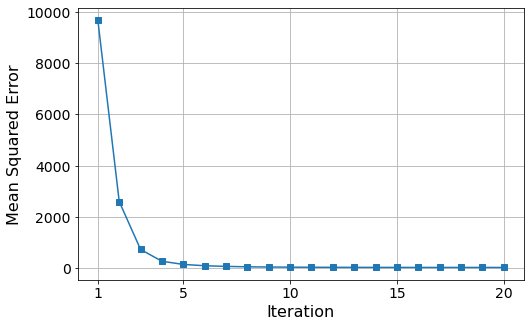

In [8]:
plot_IP_loss_evolution(return_dict,
                       start_iteration = 1,
                       reg_line = False,
                       xlabel = "Iteration",
                       save = "../img/inverse_problem/loss_single_linear_Noise.png")

Substituting symbol G from STIXNonUnicode
Substituting symbol G from STIXNonUnicode


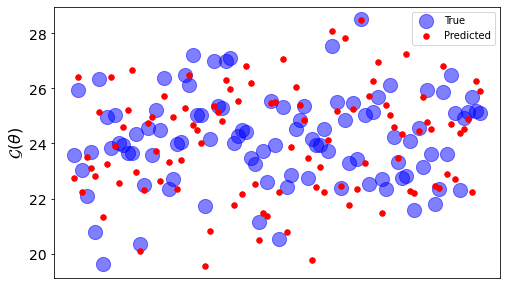

In [10]:
plot_IP_true_false(setting_dict,
                   return_dict,
                   num_points = 100,
                   x_axis = False,
                   save = "../img/inverse_problem/true_pred_linear_Noise.png")

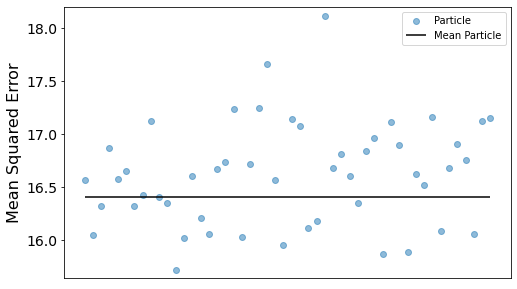

In [12]:
plot_IP_particle_loss(return_dict,
                      rel_limit_exceed = 0.005,
                      save = "../img/inverse_problem/particles_linear_Noise.png")

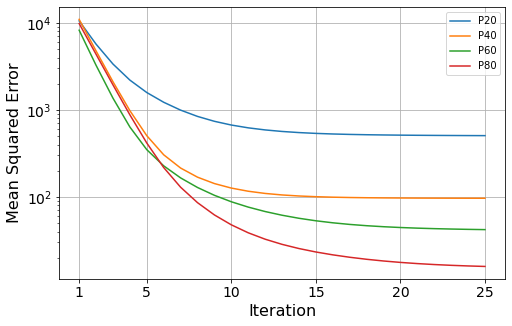

In [11]:
particle_list = [20, 40, 60, 80]

plot_IP_loss_evolution_many(setting_dict,
                            particle_list,
                            start_iteration = 1,
                            end_iteration = setting_dict["iterations"],
                            log = True,
                            xlabel = "Iteration",
                            analysis_dict = None,
                            linear = True,
                            save = "../img/inverse_problem/loss_many_linear_Noise.png")

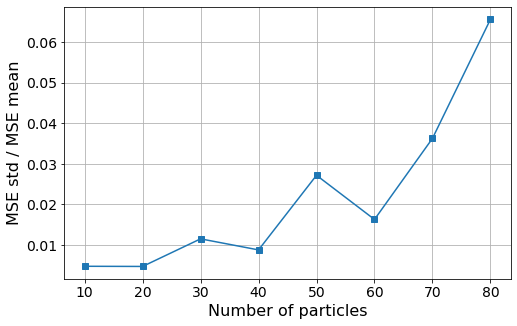

In [12]:
particle_list = [10, 20, 30, 40, 50, 60, 70, 80]

plot_IP_particle_std(setting_dict,
                     particle_list,
                     save = "../img/inverse_problem/std_particles_linear_Noise.png")

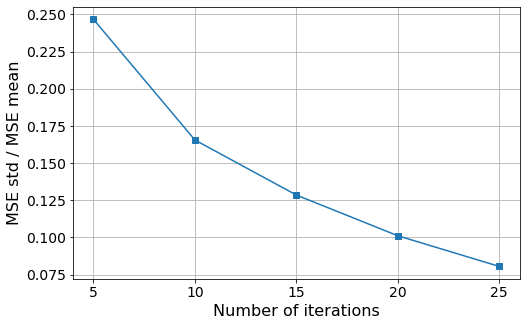

In [24]:
iteration_list = [5, 10, 15, 20, 25]

plot_IP_iteration_std(setting_dict,
                      iteration_list,
                      xlabel = "Iteration",
                      save = "../img/inverse_problem/std_iteration_linear_Noise.png")

# Nichtlineares Modell

## Modell:
$sin(x)=y$

$x$ wird gesucht.

In [14]:
x = np.random.uniform(low = 0,
                      high = 7,
                      size = (100, ))

In [15]:
def model_func(x):
    return np.sin(x)

In [16]:
noise = False

y, std = y_noise(model_func,
                 x, 
                 noise)

In [17]:
setting_dict = {"model_func": model_func,
                "x": x,
                "y": y,
                "particles": 50,
                "iterations": 25,
                "noise": noise,
                "std": std,
                "h_0": 2,
                "epsilon": 0.5,
                }

In [18]:
return_dict = enkf_inverse_problem(setting_dict)

final_params = return_dict["final_params"]
loss_evolution = return_dict["loss_evolution"]
loss_evolution_single_dict = return_dict["loss_evolution_single_dict"]

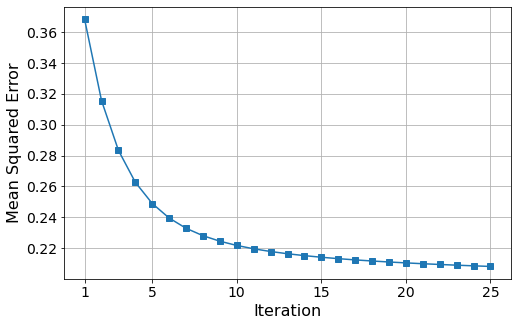

In [19]:
plot_IP_loss_evolution(return_dict,
                       start_iteration = 1,
                       reg_line = False,
                       xlabel = "Iteration",
                       save = "../img/inverse_problem/loss_single_nonlinear_noNoise.png")

Substituting symbol G from STIXNonUnicode
Substituting symbol G from STIXNonUnicode


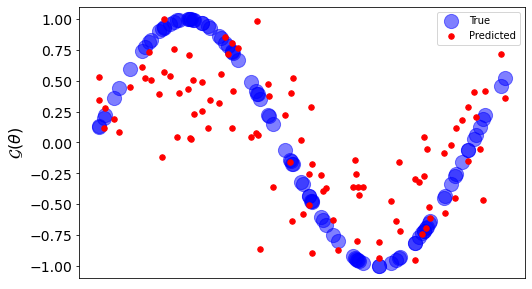

In [20]:
plot_IP_true_false(setting_dict,
                   final_params,
                   num_points = None,
                   x_axis = True,
                   save = "../img/inverse_problem/true_pred_nonlinear_noNoise.png")

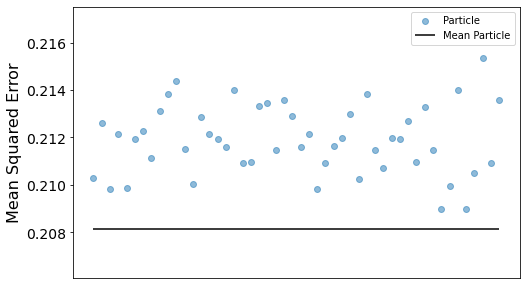

In [21]:
plot_IP_particle_loss(loss_evolution,
                      loss_evolution_single_dict,
                      rel_limit_exceed = 0.01,
                      save = "../img/inverse_problem/particles_nonlinear_noNoise.png")

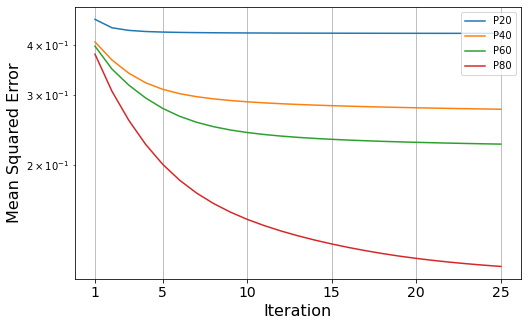

In [22]:
particle_list = [20, 40, 60, 80]

plot_IP_loss_evolution_many(setting_dict,
                            particle_list,
                            start_iteration = 1,
                            end_iteration = setting_dict["iterations"],
                            log = True,
                            xlabel = "Iteration",
                            analysis_dict = None,
                            linear = False,
                            save = "../img/inverse_problem/loss_many_nonlinear_noNoise.png")

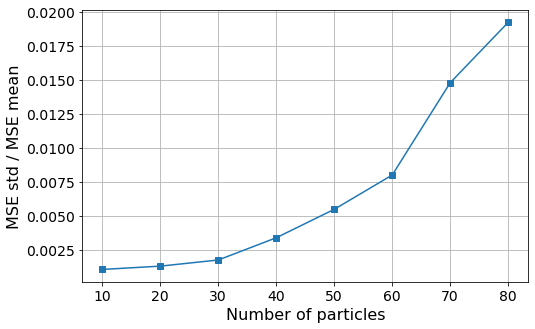

In [26]:
particle_list = [10, 20, 30, 40, 50, 60, 70, 80]

plot_IP_particle_std(setting_dict,
                     particle_list,
                     save = "../img/inverse_problem/std_particles_nonlinear_noNoise.png")

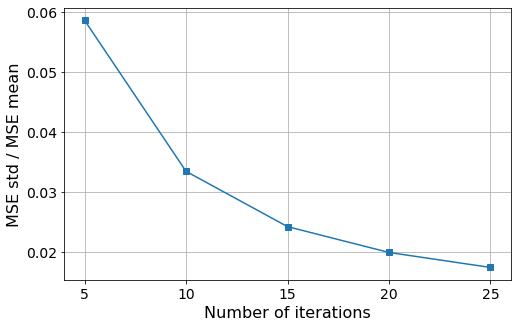

In [27]:
iteration_list = [5, 10, 15, 20, 25]

plot_IP_iteration_std(setting_dict,
                      iteration_list,
                      xlabel = "Iteration",
                      save = "../img/inverse_problem/std_iteration_nonlinear_noNoise.png")

## Modell:
$\sin(x)=y + \eta$ mit $\eta\sim\mathscr{N}(0,\Gamma)$

$x$ wird gesucht.

In [3]:
x = np.random.uniform(low = 0,
                      high = 7,
                      size = (100, ))

In [4]:
def model_func(x):
    return np.sin(x)

In [5]:
noise = True

y, std = y_noise(model_func,
                 x, 
                 noise)

In [6]:
setting_dict = {"model_func": model_func,
                "x": x,
                "y": y,
                "particles": 50,
                "iterations": 20,
                "noise": noise,
                "std": std,
                "h_0": 2,
                "epsilon": 0.5,
                }

In [15]:
return_dict = enkf_inverse_problem(setting_dict)

final_params = return_dict["final_params"]
loss_evolution = return_dict["loss_evolution"]
loss_evolution_single_dict = return_dict["loss_evolution_single_dict"]

No handles with labels found to put in legend.


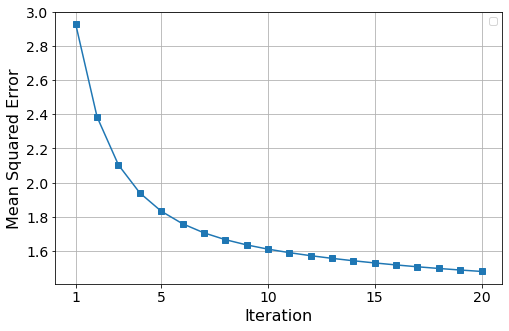

In [16]:
plot_IP_loss_evolution(return_dict,
                       start_iteration = 1,
                       reg_line = False,
                       xlabel = "Iteration",
                       save = "../img/inverse_problem/loss_single_nonlinear_Noise.png")

Substituting symbol G from STIXNonUnicode
Substituting symbol G from STIXNonUnicode


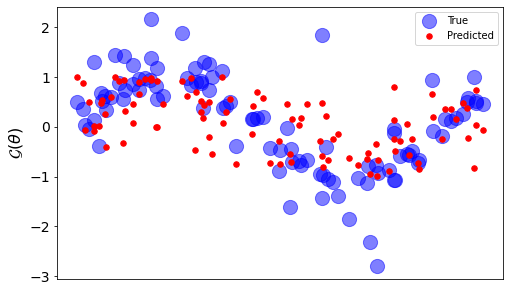

In [17]:
plot_IP_true_false(setting_dict,
                   final_params,
                   num_points = None,
                   x_axis = True,
                   save = "../img/inverse_problem/true_pred_nonlinear_Noise.png")

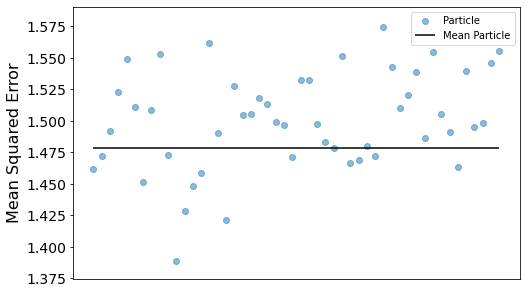

In [18]:
plot_IP_particle_loss(loss_evolution,
                      loss_evolution_single_dict,
                      rel_limit_exceed = 0.01,
                      save = "../img/inverse_problem/particles_nonlinear_Noise.png")

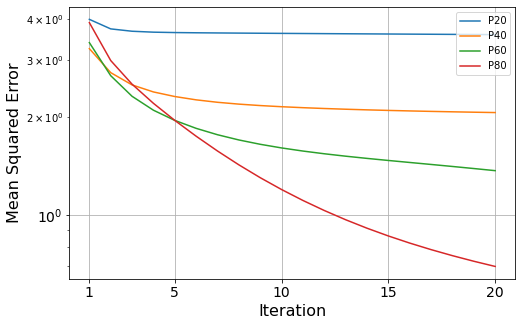

In [26]:
particle_list = [20, 40, 60, 80]

plot_IP_loss_evolution_many(setting_dict,
                            particle_list,
                            start_iteration = 1,
                            end_iteration = setting_dict["iterations"],
                            log = True,
                            xlabel = "Iteration",
                            analysis_dict = None,
                            linear = False,
                            save = "../img/inverse_problem/loss_many_nonlinear_Noise.png")

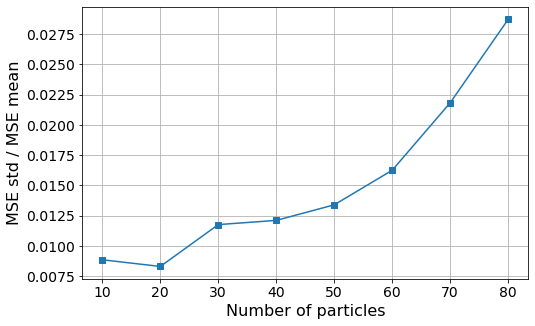

In [51]:
particle_list = [10, 20, 30, 40, 50, 60, 70, 80]

plot_IP_particle_std(setting_dict,
                     particle_list,
                     save = "../img/inverse_problem/std_particles_nonlinear_Noise.png")

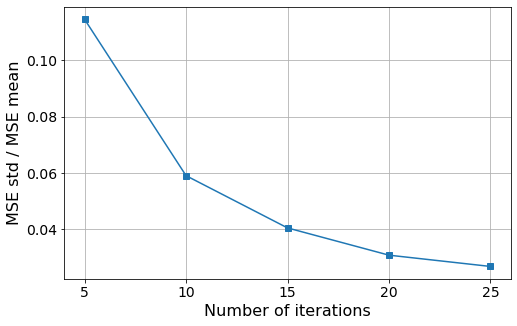

In [52]:
iteration_list = [5, 10, 15, 20, 25]

plot_IP_iteration_std(setting_dict,
                      iteration_list,
                      xlabel = "Iteration",
                      save = "../img/inverse_problem/std_iteration_nonlinear_Noise.png")